In [10]:
import nltk
import pandas as pd
from nltk.corpus import gutenberg
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
leaves=gutenberg.paras('whitman-leaves.txt')
#processing
leaves_paras=[]
for paragraph in leaves:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    leaves_paras.append(' '.join(para))

print(leaves_paras[0:4])

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/justinsmith/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
['[ Leaves of Grass by Walt Whitman 1855 ]', "Come , said my soul , Such verses for my Body let us write , ( for we are one ,) That should I after return , Or , long , long hence , in other spheres , There to some group of mates the chants resuming , ( Tallying Earth ' s soil , trees , winds , tumultuous waves ,) Ever with pleas ' d smile I may keep on , Ever and ever yet the verses owning  as , first , I here and now Signing for Soul and Body , set to them my name ,", 'Walt Whitman', '[ BOOK I . INSCRIPTIONS ]']


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(leaves_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
leaves_paras_tfidf=vectorizer.fit_transform(leaves_paras)
print("Number of features: %d" % leaves_paras_tfidf.get_shape()[1])

# #splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(leaves_paras_tfidf, test_size=0.4, random_state=0)


# #Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# #number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 4986
Original sentence: } Song of Prudence
Tf_idf vector: {'prudence': 0.8276958817743998, 'song': 0.5611769126520607}


In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: 29.72910804145215
Component 0:
[ BOOK XXIV .                0.999549
[ BOOK XVII .                0.999549
[ BOOK I . INSCRIPTIONS ]    0.999549
[ BOOK XVI ]                 0.999549
[ BOOK XXXIII .              0.999549
[ BOOK XVIII ]               0.999549
[ BOOK XIX .                 0.999549
[ BOOK XIII ]                0.999549
[ BOOK XXXI ]                0.999549
[ BOOK X ]                   0.999549
Name: 0, dtype: float64
Component 1:
3 The log at the wood - pile , the axe supported by it , The sylvan hut , the vine over the doorway , the space clear ' d for garden , The irregular tapping of rain down on the leaves after the storm is lull ' d , The walling and moaning at intervals , the thought of the sea , The thought of ships struck in the storm and put on their beam ends , and the cutting away of masts , The sentiment of the huge timbers of old - fashion ' d houses and barns , The remember ' d print or narrative , the voyage at a

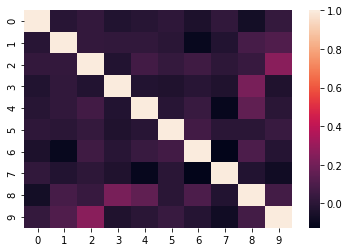

Key:
0 } On the Beach at Night
1 I need no assurances , I am a man who is preoccupied of his own soul ; I do not doubt that from under the feet and beside the hands and face I am cognizant of , are now looking faces I am not cognizant of , calm and actual faces , I do not doubt but the majesty and beauty of the world are latent in any iota of the world , I do not doubt I am limitless , and that the universes are limitless , in vain I try to think how limitless , I do not doubt that the orbs and the systems of orbs play their swift sports through the air on purpose , and that I shall one day be eligible to do as much as they , and more than they , I do not doubt that temporary affairs keep on and on millions of years , I do not doubt interiors have their interiors , and exteriors have their exteriors , and that the eyesight has another eyesight , and the hearing another hearing , and the voice another voice , I do not doubt that the passionately - wept deaths of young men are provided f

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


In [16]:
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    # Better get rid of it now!
    text = re.sub(r'--',' ',text)
    
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of chapter titles.
    text = re.sub(r'Chapter \d+','',text)
    
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    
    return text

In [19]:
leaves_raw = gutenberg.raw('whitman-leaves.txt')
leaves_clean = text_cleaner(leaves_raw)

In [21]:
import spacy
nlp = spacy.load('en')

In [22]:
leaves_doc = nlp(leaves_raw)

In [23]:
sentences = []
for sentence in leaves_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)


print(sentences[20])
print('We have {} sentences and {} tokens.'.format(len(sentences), len(leaves_clean)))

['in', "cabin'd", 'ships', 'sea', '\n\n', 'in', "cabin'd", 'ship', 'sea', '\n', 'the', 'boundless', 'blue', 'expand', '\n', 'with', 'whistle', 'wind', 'music', 'wave', 'large', 'imperious', 'wave', '\n', 'or', 'lone', 'bark']
We have 6808 sentences and 692312 tokens.


In [24]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    sentences,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [25]:
vocab = model.wv.vocab.keys()

In [26]:
print(model.wv.most_similar(positive=['lady', 'man'], negative=['woman']))

[('1', 0.9771538972854614), ("turn'd", 0.9767134785652161), ('thought', 0.9739528298377991), ('carol', 0.971439003944397), ("stretch'd", 0.9711639285087585), ('near', 0.9710549116134644), ('9', 0.9701783061027527), ('fight', 0.968807578086853), ('now', 0.9681072235107422), ('offspring', 0.9674395322799683)]


In [34]:
print(model.wv.similarity('wind', 'wave'))
print(model.wv.similarity('sweet', 'happy'))

0.93035674
0.9855194
